In [1]:
import collections
import itertools
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [2]:
language = "javascript"
path_to_lib = f"data/results/{language}"

In [3]:
with open(f"{path_to_lib}/{language}_{language}_daily_post_stats.json") as handle:
    daily_post_count = json.load(handle)

with open(f"{path_to_lib}/{language}_{language}_post_stats.json") as handle:
    post_stats = json.load(handle)

with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

with open(f"{path_to_lib}/{language}_all_pairs_dates.json") as handle:
    pairs_dates = json.load(handle)

with open(f"{path_to_lib}/{language}_user_to_posts.json") as handle:
    user_to_posts = json.load(handle)

In [4]:
# This may not be necessary as the input seems already sorted, but let us code this defensively.
sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))

# Probability distributions of a rank $r$ post being novelty/ valuable novelty


Replay the posts in order and collect the following data:
 - number of post created by every user at the time of the kth post
 - identify if the kth post is a novelty / valuable novelty. Based on that,
 - rank of every post: the number of posts that had been created by the same user (including the current one)
 - distribution of post ranks, novelty post ranks, valuable novelty post ranks. Based on that,
 
 *** probability distributions $p_n(r)$ and $p_{vn}(r)$ of a rank $r$ post being novelty/ valuable novelty. ***


In [5]:
VALUE_THRESHOLDS = [2, 5]#[25, 50, 100, 200]
VALUE_TIME_WINDOW = datetime.timedelta(days=365)
BIN_BORDERS = [1, 10, 25, 50, 100, 200, np.infty]  


user_posts = collections.defaultdict(set)
novel_post_stats = []
post_rank_count = collections.defaultdict(int)
novel_post_rank_count = collections.defaultdict(int)
valuable_novel_post_rank_count = {
    k: collections.defaultdict(int) for k in VALUE_THRESHOLDS
}
stats = collections.defaultdict(int)
for post_stat in tqdm.tqdm(sorted_post_stats):
    try:
        user_posts[post_stat["poster_id"]].add(post_stat["id"])
        post_rank = len(user_posts[post_stat["poster_id"]])
        novelty_count = 0
        is_valuable = {k: False for k in VALUE_THRESHOLDS}
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                novelty_count += 1
                for value_threshold in VALUE_THRESHOLDS:
                    # Decide if the pair in the post received enough traction within the prescribed time window.
                    relevant_dates = [
                        dt for dt in pairs_dates[canonical_pair_name]if (
                            datetime.datetime.strptime(dt, "%Y-%m-%d") <
                            datetime.datetime.strptime(pairs_first_dates[canonical_pair_name]["date"], "%Y-%m-%d") + VALUE_TIME_WINDOW
                        )
                    ]
                    if len(relevant_dates) >= value_threshold:
                        is_valuable[value_threshold] = True
                novel_post_stats.append(
                    {
                        "poster_id": post_stat["poster_id"],
                        "id": post_stat["id"],
                        "post_rank": len(user_posts[post_stat["poster_id"]]),
                        "canonical_pair_name": canonical_pair_name,
                        "pair_total_use_within_window": len(relevant_dates),
                        "date": datetime.datetime.strptime(post_stat["date"], "%Y-%m-%dT%H:%M:%S.%f"),
                    }
                )
        if novelty_count > 0:
            stats["novelty_post_count"] += 1
            novel_post_rank_count[post_rank] += 1

            # Decide if the post is valuable
            for value_threshold in VALUE_THRESHOLDS:
                if is_valuable[value_threshold]:
                    valuable_novel_post_rank_count[value_threshold][post_rank] += 1
        else:
            stats["non_novel_post_count"] += 1
        stats["total_post_count"] += 1
        post_rank_count[post_rank] += 1
    except Exception as exc:
        stats[exc] += 1

print("STATS:")
for k, v in stats.items():
    print(f"\t{k}: {v}")

# Calculate it for the richest domain of the valuable ratios, that is, for the smallest threshold.
novel_ratio = {
    k: novel_post_rank_count.get(k, 0) / post_rank_count.get(k, 1)
    for k in sorted(valuable_novel_post_rank_count[min(VALUE_THRESHOLDS)].keys())
}

valuable_novel_ratio = {}
for value_threshold in VALUE_THRESHOLDS:
    valuable_novel_ratio[value_threshold] = {
        k: valuable_novel_post_rank_count[value_threshold].get(k, 0) / post_rank_count.get(k, 1)
        for k in sorted(valuable_novel_post_rank_count[value_threshold].keys())
    }

100%|█| 265233/265233 [00:16<00:00,

STATS:
	novelty_post_count: 33390
	total_post_count: 265233
	non_novel_post_count: 231843


(0.0, 0.2)

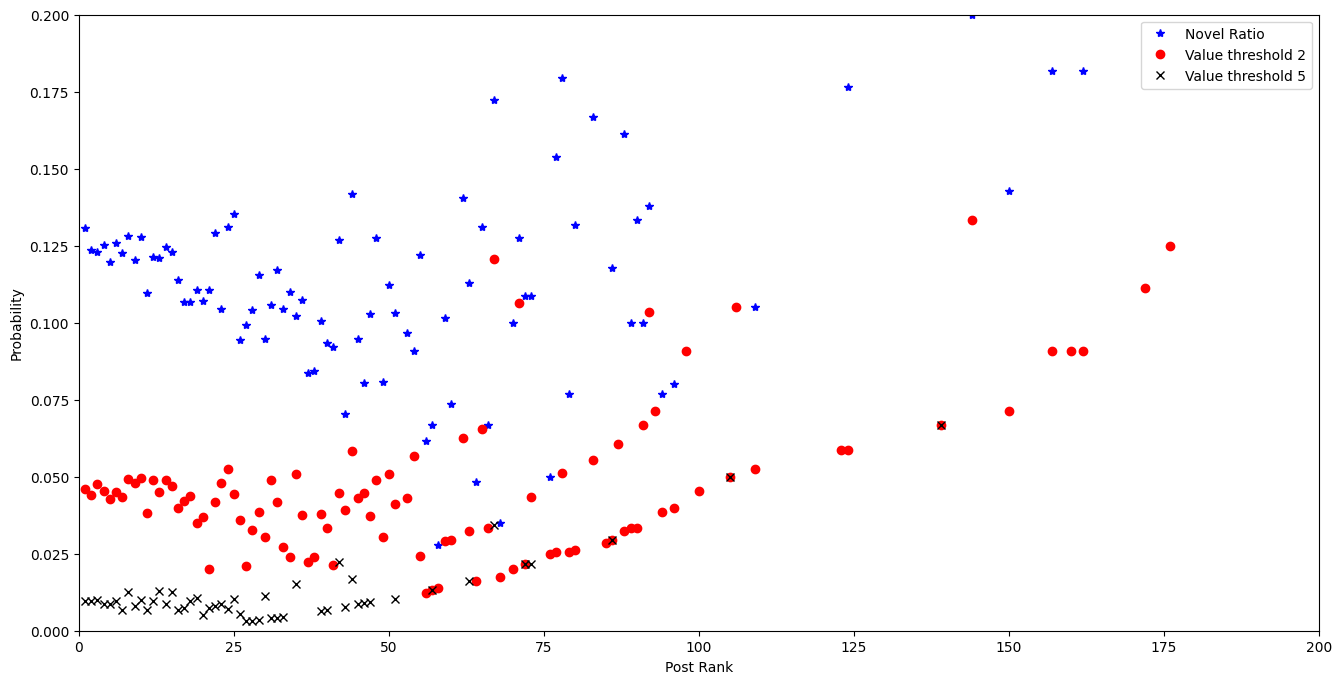

In [6]:
plt.figure(figsize=(16,8))
plt.plot(sorted(novel_ratio.keys()), [novel_ratio[x] for x in sorted(novel_ratio.keys())], "b*", label="Novel Ratio")
forms = "ox^."
colors ="rkgm"
for index, value_threshold in enumerate(VALUE_THRESHOLDS):
    plt.plot(
        sorted(valuable_novel_ratio[value_threshold].keys()),
        [valuable_novel_ratio[value_threshold][x] for x in sorted(valuable_novel_ratio[value_threshold].keys())],
        f"{colors[index]}{forms[index]}", label=f"Value threshold {value_threshold}")
plt.legend()
plt.xlabel("Post Rank")
plt.ylabel("Probability")
plt.xlim(0, 200)
plt.ylim(0, 0.2)
#plt.semilogx()


Text(0, 0.5, 'Probability of being novel/valuable novel')

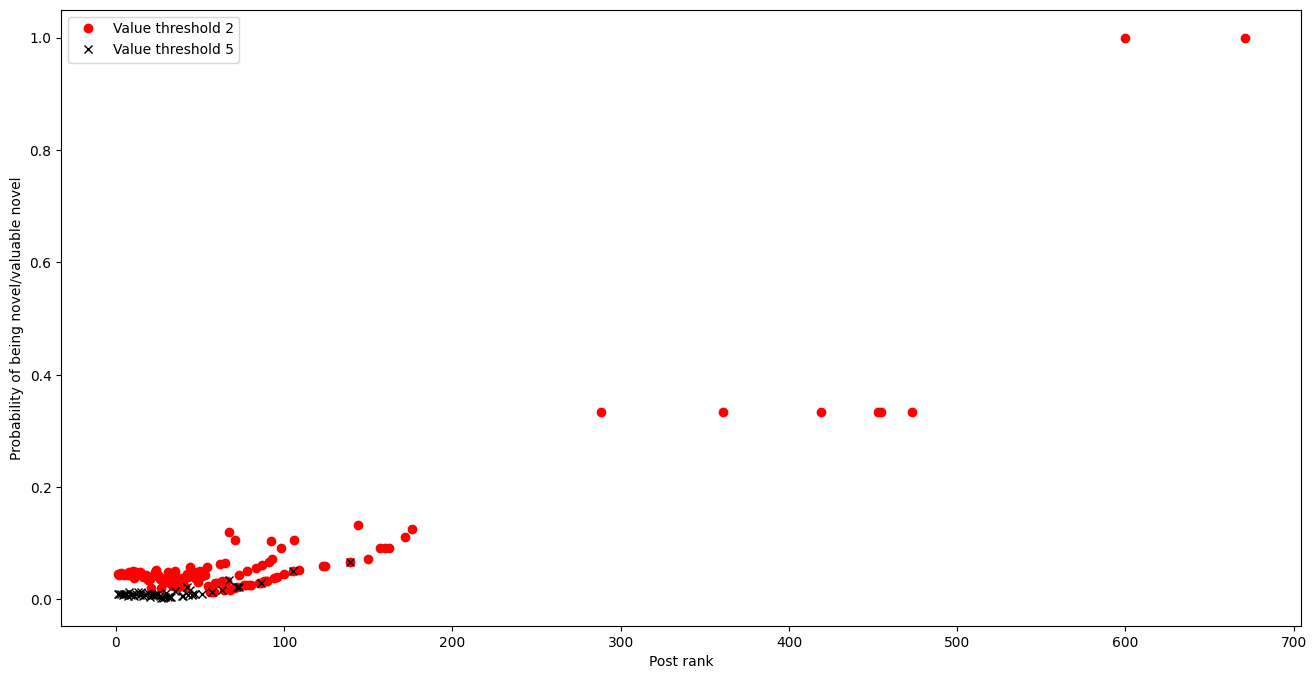

In [7]:
plt.figure(figsize=(16,8))
forms = "ox^."
colors ="rkgm"
for index, value_threshold in enumerate(VALUE_THRESHOLDS):
    plt.plot(
        sorted(valuable_novel_ratio[value_threshold].keys()),
        [valuable_novel_ratio[value_threshold][x] for x in sorted(valuable_novel_ratio[value_threshold].keys())],
        f"{colors[index]}{forms[index]}", label=f"Value threshold {value_threshold}")
plt.legend()
#plt.xlim(0, 150)
#plt.ylim(0, 0.02)
plt.xlabel("Post rank")
plt.ylabel("Probability of being novel/valuable novel")

## Comparison of rank distributions among all posts vs novel posts

In [8]:
impacts = pd.DataFrame(novel_post_stats)

#impacts["cm_impact"] = impacts.groupby(["poster_id", "id", "post_rank"])["pair_total_use"].transform("sum")
# for now, we should only focus on the highest, not the cumulative impact. 10 lib pairs of 20 cites each != one pair with 200 cites.
impacts["max_impact"] = impacts.groupby(["poster_id", "id", "post_rank"])["pair_total_use_within_window"].transform("max")
impacts_unique = impacts.drop_duplicates(subset=['id'], keep='first'); impacts_unique

,poster_id,id,post_rank,canonical_pair_name,pair_total_use_within_window,date,max_impact
0,4875,48497,1,dijit|dojo,6,2008-09-07 15:02:09.897,6
1,26394,300892,1,dojox|my,1,2008-11-19 03:08:35.527,1
2,20386,477053,1,dijit|dojo-release-1,2,2009-01-25 02:05:54.433,9
7,6007,1875754,1,posix|sys,2,2009-12-09 18:12:06.210,2
8,36047,1972242,1,|http,3,2009-12-29 00:08:49.407,3
...,...,...,...,...,...,...,...
119702,22850185,77588882,1,util|validator,1,2023-12-02 01:52:55.767,1
119703,23024866,77589261,1,@mantine|@tabler,1,2023-12-02 05:32:06.503,1
119704,818827,77589549,2,@vue|vue-demi,1,2023-12-02 07:51:44.747,1
119705,23026826,77590556,1,|@invertase,1,2023-12-02 13:32:25.927,1


In [9]:
def custom_bin(x):
    global BIN_BORDERS
    for border in BIN_BORDERS:
        if x <= border:
            return f"<={border}"
    return "INF"

/tmp/ipykernel_18427/26165548.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_unique["custom_bin"] = impacts_unique.post_rank.map(custom_bin)


array([<Axes: ylabel='Novel Posts'>], dtype=object)

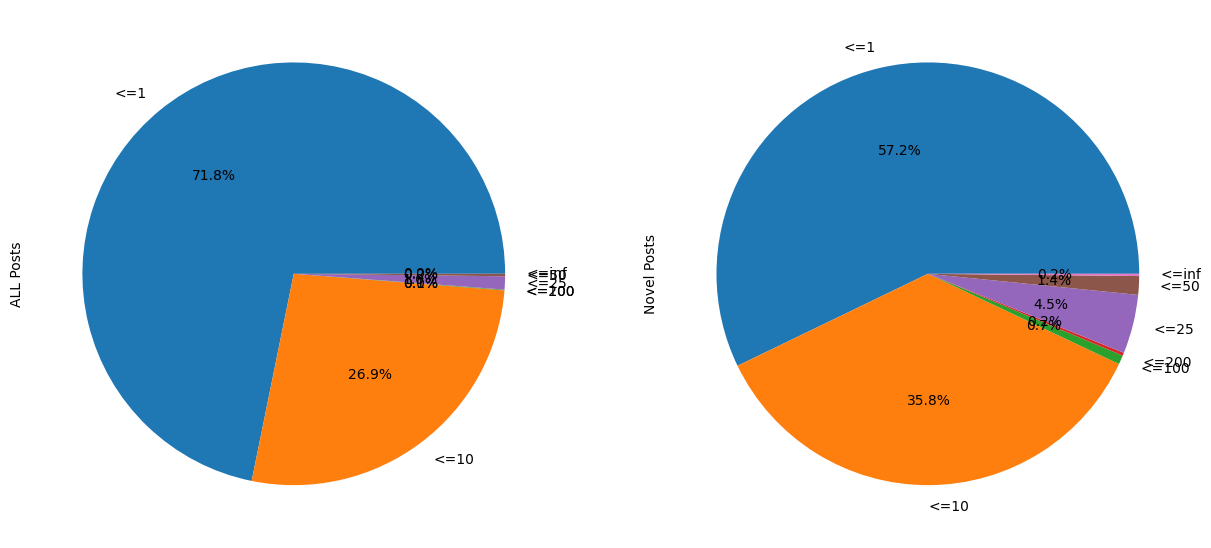

In [10]:
# compare this with the post distribution among users using ALL posts.
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,15))

# All posts chart
all_posts = pd.DataFrame({k: len(v) for k, v in user_to_posts.items()}.items(), columns=["user_id", "post_count"])
all_posts["custom_bin"] = all_posts.post_count.map(custom_bin)
all_posts.groupby(["custom_bin"])["user_id"].count().plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[0], subplots=True, label="ALL Posts")

# Novelty Chart
impacts_unique["custom_bin"] = impacts_unique.post_rank.map(custom_bin)
impacts_unique.groupby(["custom_bin"])["id"].count().plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[1], subplots=True, label="Novel Posts")

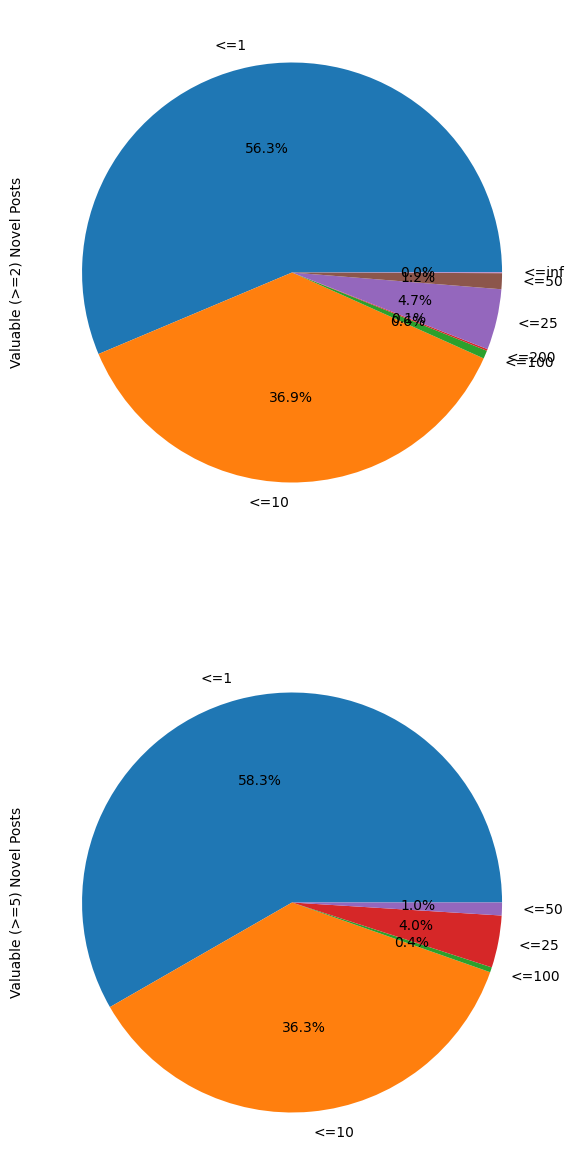

In [11]:
# Valuable Novelty
fig, axes = plt.subplots(nrows=len(VALUE_THRESHOLDS),ncols=1, figsize=(15,15))
val_impacts = {k: impacts_unique[impacts_unique.max_impact > k] for k in VALUE_THRESHOLDS}
for index, k in enumerate(VALUE_THRESHOLDS):
    val_impacts[k].groupby(["custom_bin"])["id"].count().plot.pie(
        autopct='%1.1f%%', startangle=0, ax=axes[index],
        subplots=True, label=f"Valuable (>={k}) Novel Posts")

# Distribution of user seniority over the years

In [12]:
impacts_unique

,poster_id,id,post_rank,canonical_pair_name,pair_total_use_within_window,date,max_impact,custom_bin
0,4875,48497,1,dijit|dojo,6,2008-09-07 15:02:09.897,6,<=1
1,26394,300892,1,dojox|my,1,2008-11-19 03:08:35.527,1,<=1
2,20386,477053,1,dijit|dojo-release-1,2,2009-01-25 02:05:54.433,9,<=1
7,6007,1875754,1,posix|sys,2,2009-12-09 18:12:06.210,2,<=1
8,36047,1972242,1,|http,3,2009-12-29 00:08:49.407,3,<=1
...,...,...,...,...,...,...,...,...
119702,22850185,77588882,1,util|validator,1,2023-12-02 01:52:55.767,1,<=1
119703,23024866,77589261,1,@mantine|@tabler,1,2023-12-02 05:32:06.503,1,<=1
119704,818827,77589549,2,@vue|vue-demi,1,2023-12-02 07:51:44.747,1,<=10
119705,23026826,77590556,1,|@invertase,1,2023-12-02 13:32:25.927,1,<=1


33390it [00:01, 19635.34it/s]


Text(0, 0.5, 'Probability of a novel post coming from the given rank intervals')

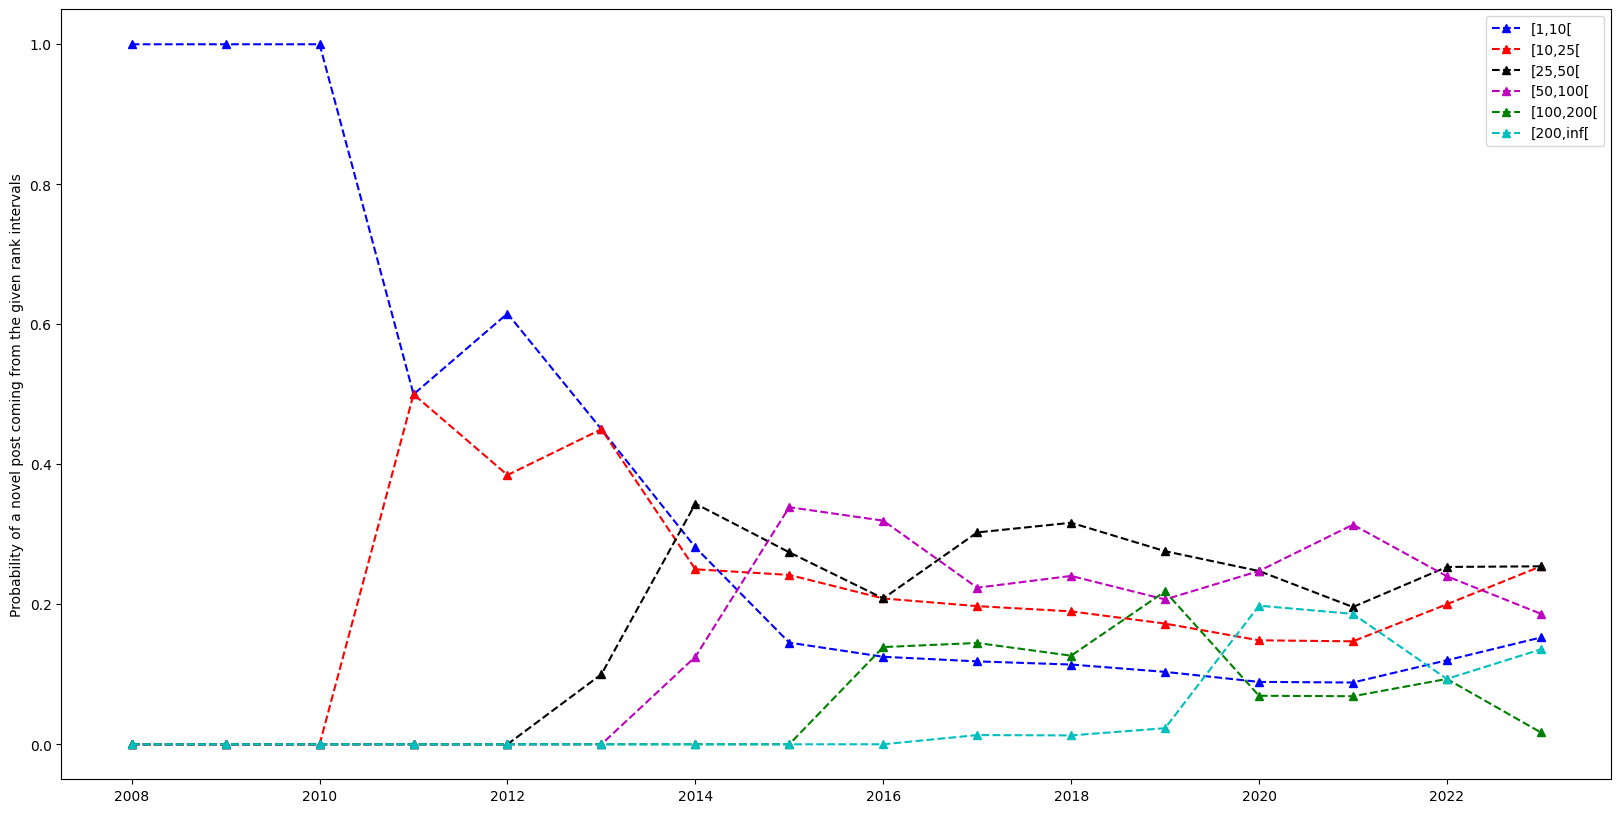

In [13]:
# Build annual distibutions
annual_rank_distros = collections.defaultdict(lambda: collections.defaultdict(int))
for index, row in tqdm.tqdm(impacts_unique.iterrows()):
            annual_rank_distros[row.date.year][row.post_rank] += 1

plt.figure(figsize=(20, 10))

for border_a, border_b, color in zip(BIN_BORDERS, BIN_BORDERS[1:], "brkmgc" ):
    xs = annual_rank_distros.keys()
    ys = [
        len([item for item in annual_rank_distros[year] if border_a <= item < border_b]) /
        len(annual_rank_distros[year])
        for year in xs
    ]
    plt.plot(xs, ys, f"^--{color}", label=f"[{border_a},{border_b}[")
plt.legend()
plt.ylabel("Probability of a novel post coming from the given rank intervals")

765it [00:00, 16999.34it/s]


Text(0, 0.5, 'Probability of a valuable novel post coming from the given rank intervals')

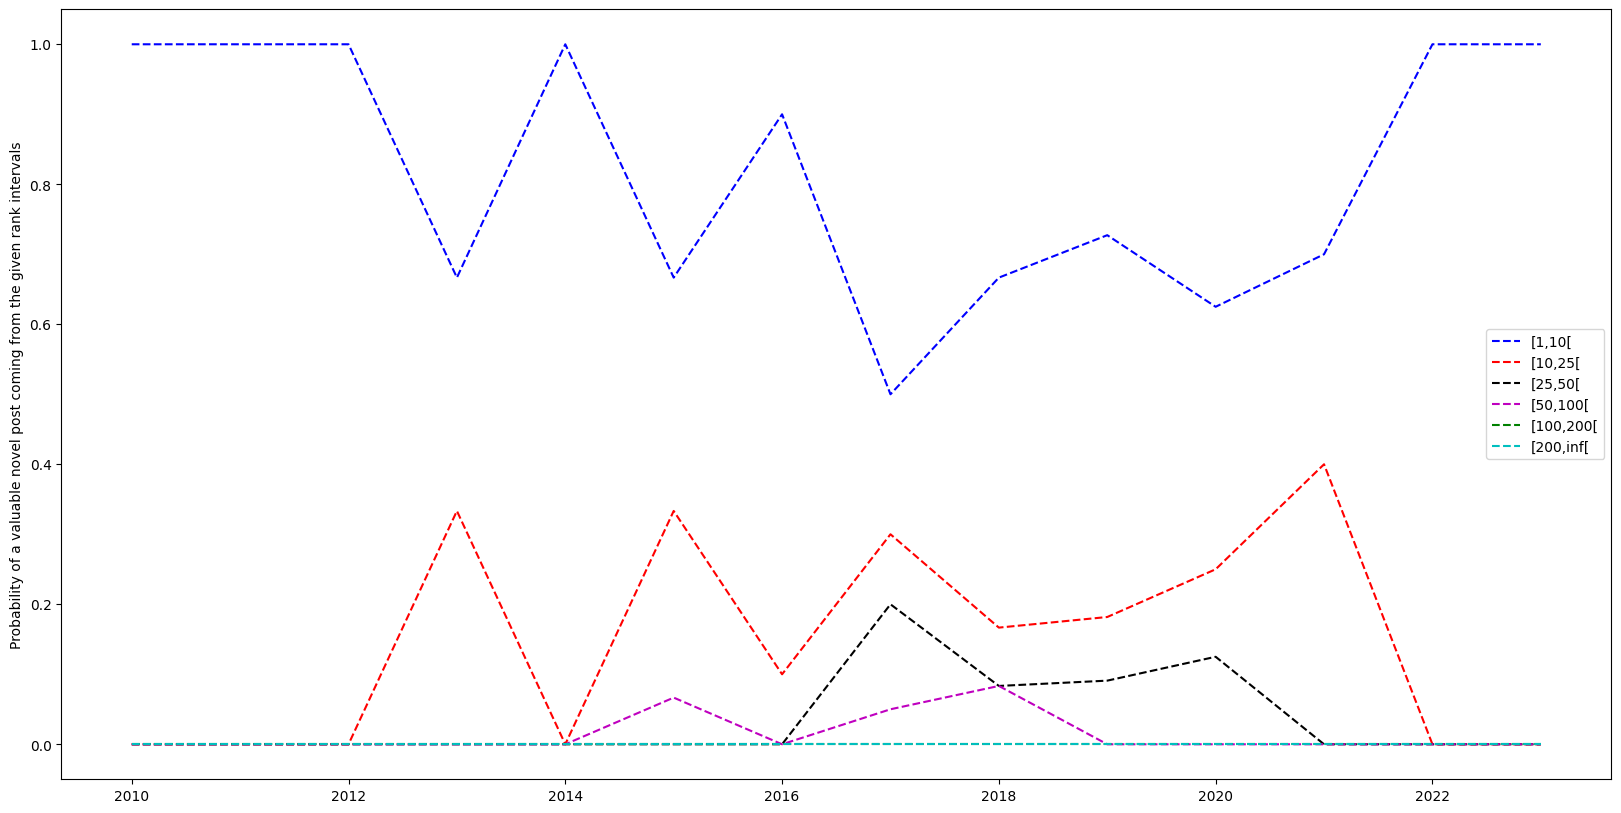

In [14]:
val_impacts = impacts_unique[impacts_unique['max_impact'] >= 10]

# Build annual distibutions
val_annual_rank_distros = collections.defaultdict(lambda: collections.defaultdict(int))
for index, row in tqdm.tqdm(val_impacts.iterrows()):
            val_annual_rank_distros[row.date.year][row.post_rank] += 1

plt.figure(figsize=(20, 10))

for border_a, border_b, color in zip(BIN_BORDERS, BIN_BORDERS[1:], "brkmgc" ):
    xs = val_annual_rank_distros.keys()
    ys = [
        len([item for item in val_annual_rank_distros[year] if border_a <= item <= border_b]) /
        len(val_annual_rank_distros[year])
        for year in xs
    ]
    plt.plot(xs, ys, f"--{color}", label=f"[{border_a},{border_b}[")
plt.legend()
plt.ylabel("Probability of a valuable novel post coming from the given rank intervals")

## Number of posts, novelties, valuable novelties distributed across the years

[]

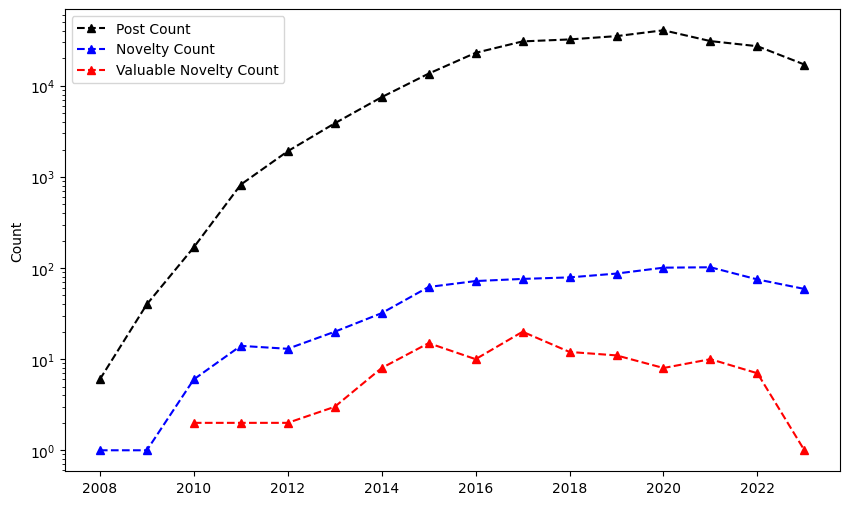

In [15]:
plt.figure(figsize=(10,6))

annual_post_count = collections.defaultdict(int)
for k, v in daily_post_count.items():
    annual_post_count[int(k[:4])] += v
plt.plot(sorted(annual_post_count.keys()), [annual_post_count[x] for x in sorted(annual_post_count)], "k^--", label="Post Count")

xs = annual_rank_distros.keys()
ys = [len(annual_rank_distros[year]) for year in xs]
plt.plot(xs, ys, "b^--", label="Novelty Count")

xs = val_annual_rank_distros.keys()
ys = [len(val_annual_rank_distros[year]) for year in xs]


plt.plot(xs, ys, "r^--", label="Valuable Novelty Count")
plt.legend()
plt.ylabel("Count")
plt.semilogy()

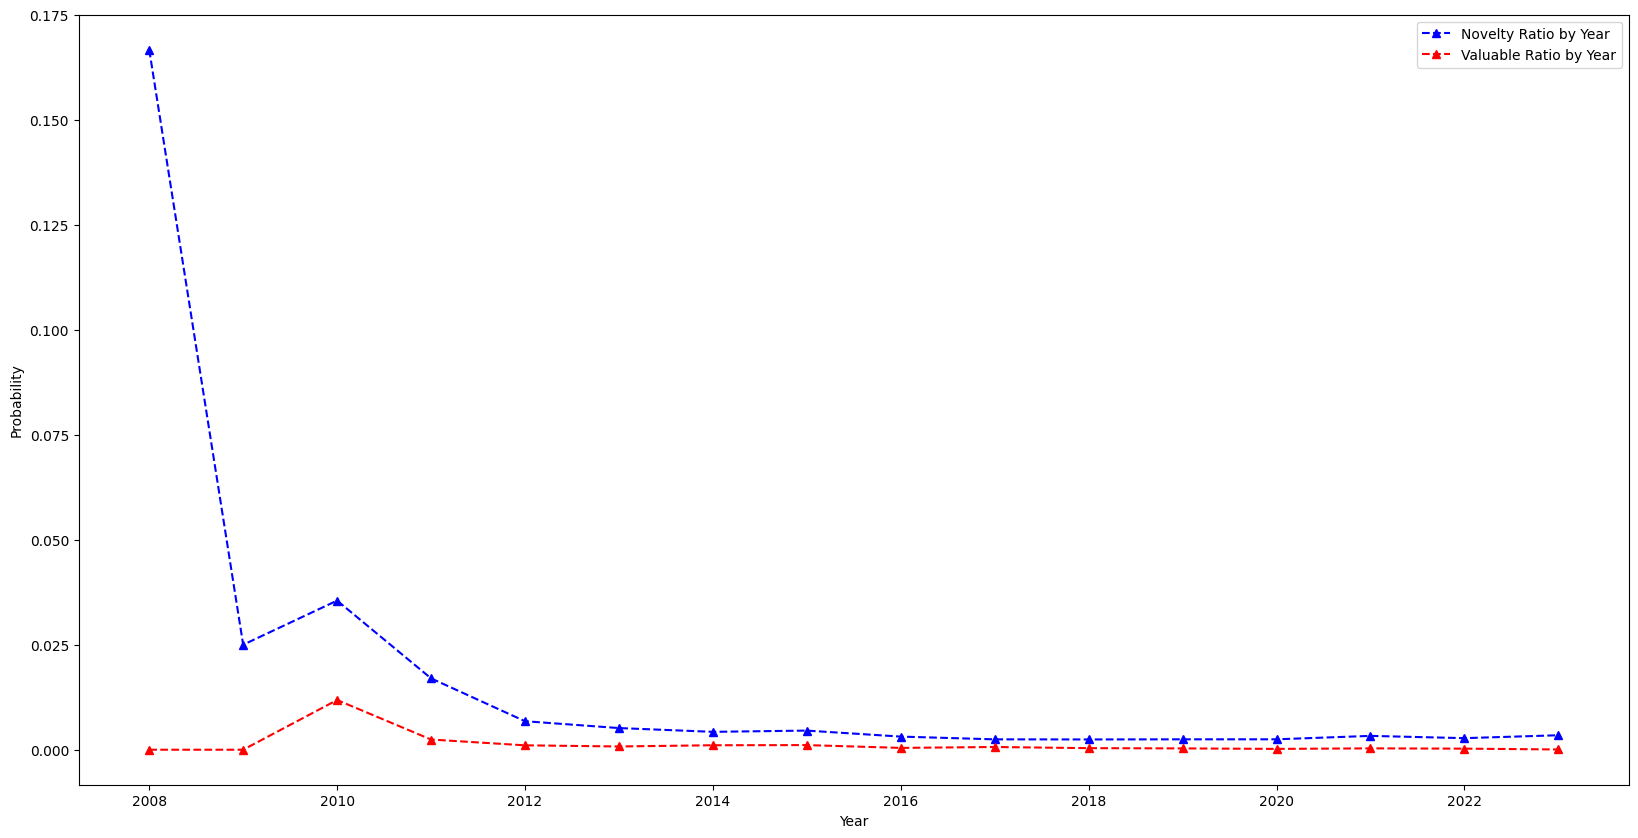

In [16]:
plt.figure(figsize=(20,10))

xs = annual_post_count.keys()
plt.plot(xs, [len(annual_rank_distros[year])/annual_post_count[year] for year in xs], "b^--", label="Novelty Ratio by Year")
plt.plot(xs, [len(val_annual_rank_distros[year])/annual_post_count[year] for year in xs], "r^--", label="Valuable Ratio by Year")
plt.xlabel("Year")
plt.ylabel("Probability")
plt.legend()

In [17]:
[len(val_annual_rank_distros[year]) for year in xs]

[0, 0, 2, 2, 2, 3, 8, 15, 10, 20, 12, 11, 8, 10, 7, 1]